In [84]:
import os
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf

In [7]:
ratings_df = pd.read_csv("./movielens/ratings.csv", encoding = 'utf-8')

In [14]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [15]:
ratings_df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [16]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [13]:
print("유저 수 :", len(ratings_df.userId.unique()))
print("아이템 수 :", len(ratings_df.movieId.unique()))

유저 수 : 610
아이템 수 : 9724


In [36]:
print("인당 평균 :",ratings_df.groupby("userId").count()['rating'].mean())

인당 평균 : 165.30491803278687


In [40]:
print("영화당 평균 :", ratings_df.groupby("movieId").count()['rating'].mean())

영화당 평균 : 10.369806663924312


In [19]:
import seaborn as sns

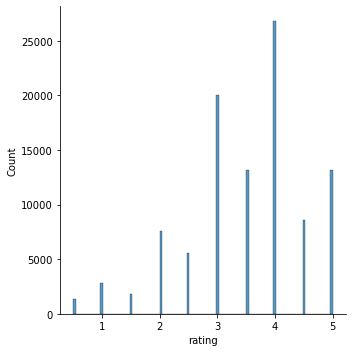

In [26]:
sns.displot(ratings_df["rating"])

<AxesSubplot:xlabel='rating', ylabel='Density'>

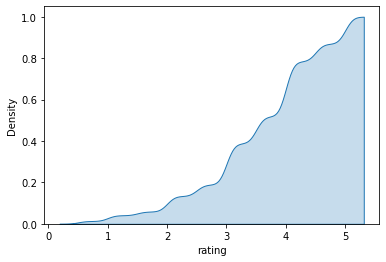

In [23]:
sns.kdeplot(ratings_df["rating"],cumulative=True, shade = True)

In [51]:
item_user_df = ratings_df.pivot_table(values="rating", index = "movieId",columns="userId")

In [52]:
item_user_df.fillna(0,inplace=True)

In [53]:
item_user_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
num_features = len(item_user_df.columns)
num_features

610

In [63]:
I_AutoRec_input = np.array(item_user_df)
I_AutoRec_input.shape

(9724, 610)

### movielens 1m 

In [222]:
ratings_df = pd.read_csv("./ml-1m/ratings.dat", sep='::', header=None, engine='python')

In [227]:
ratings_df.columns = ["userId","movieId","rating","time"]

In [228]:
item_user_df = ratings_df.pivot_table(values="rating", index = "movieId",columns="userId")

In [230]:
item_user_df.fillna(0,inplace=True)

In [232]:
I_AutoRec_input = np.array(item_user_df)

In [271]:
I_AutoRec_input.shape

(3706, 6040)

In [233]:
num_features = len(item_user_df.columns)
num_features

6040

In [310]:
from sklearn.model_selection import train_test_split

train_input, test_input = train_test_split(I_AutoRec_input,test_size = 0.1)

In [314]:
print(train_input.shape)
print(test_input.shape)

(3335, 6040)
(371, 6040)


## AutoRec

In [ ]:
"a".endswith

In [332]:
Model = keras.Sequential([
    keras.layers.Dense(300,kernel_regularizer=keras.regularizers.L2(0.01)),
    keras.layers.Dense(num_features,kernel_regularizer= keras.regularizers.L2(0.01))
])

In [333]:
def MaskedMSELoss(y_true,y_pred):
    mask = y_true != 0
    mask_float = tf.cast(mask,tf.float32)
    masked_error = mask_float*y_pred - y_true
    squared_masked_error = tf.square(masked_error) / 2
    return squared_masked_error

In [334]:
Model.compile(loss = MaskedMSELoss,
             optimizer = "SGD",
             metrics=keras.metrics.RootMeanSquaredError())

In [335]:
Model.fit(train_input,train_input,batch_size=32,epochs=100,validation_data=(test_input,test_input))

Epoch 1/100
105/105 [==============================] - 1s 9ms/step - loss: 11.7565 - root_mean_squared_error: 0.8658 - val_loss: 11.7854 - val_root_mean_squared_error: 0.9027
Epoch 2/100
105/105 [==============================] - 1s 8ms/step - loss: 11.7332 - root_mean_squared_error: 0.8358 - val_loss: 11.7795 - val_root_mean_squared_error: 0.8968
Epoch 3/100
105/105 [==============================] - 1s 9ms/step - loss: 11.7355 - root_mean_squared_error: 0.8408 - val_loss: 11.7739 - val_root_mean_squared_error: 0.8924
Epoch 4/100
105/105 [==============================] - 1s 8ms/step - loss: 11.7276 - root_mean_squared_error: 0.8330 - val_loss: 11.7681 - val_root_mean_squared_error: 0.8889
Epoch 5/100
105/105 [==============================] - 1s 8ms/step - loss: 11.7299 - root_mean_squared_error: 0.8393 - val_loss: 11.7618 - val_root_mean_squared_error: 0.8861
Epoch 6/100
105/105 [==============================] - 1s 9ms/step - loss: 11.7201 - root_mean_squared_error: 0.8315 - val_lo

KeyboardInterrupt: 